**EXAMPLE 2**
There is one angle-measuring sensor, located at $[0, 0, 0]^T$ that gives the azimuth and elevation (in radian) of the target relative to the sensor. The target moves according to the following dynamics:

$$
ds_t = As_t dt, \quad
A = \begin{bmatrix}
-\epsilon I_{3 \times 3} & I_{3 \times 3} & 0_{3 \times 3} \\
0_{3 \times 3} & -\epsilon I_{3 \times 3} & I_{3 \times 3} \\
0_{3 \times 3} & 0_{3 \times 3} & -\epsilon I_{3 \times 3}
\end{bmatrix}
$$

in which $s_t = [x_t, y_t, z_t, v_{x,t}, v_{y,t}, v_{z,t}, a_{x,t}, a_{y,t}, a_{z,t}]^T \in \mathbb{R}^9$ is a nine-dimensional vector describing the position, velocity, and acceleration of the target in space, and $\epsilon$ is a scalar constant. The truth initial state of the target is $s_0 = [40, 40, 40, 8, 0, -3, 0, 0, 0]^T$.

The nonlinear measurement equation is

$$
\mathbf{z}_t = 
\begin{bmatrix}
\arctan\left(\frac{x_t}{y_t}\right) \\
\arctan\left(\frac{z_t}{r_t}\right)
\end{bmatrix}
+
\begin{bmatrix}
v_{1,t} \\
v_{2,t}
\end{bmatrix}
$$

in which $r_t = \sqrt{x_t^2 + y_t^2}$. The measurement noise $v_t = [v_{1,t}, v_{2,t}]^T$ is Gaussian with zero mean and covariance matrix $R$.

For comparison, we also implemented the sample importance resampling particle filter.

For this example, parameter settings are as the following: The prior knowledge of initial state is Gaussian with estimates of mean $\hat{s}_0 = [50, 50, 10, 10, 40, 0, 0, 0, 0]^T$ and covariance matrix

$$
\hat{P}_0 = 
\begin{bmatrix}
10I_{3 \times 3} & 0_{3 \times 3} & 0_{3 \times 3} \\
0_{3 \times 3} & 10^4 I_{3 \times 3} & 0_{3 \times 3} \\
0_{3 \times 3} & 0_{3 \times 3} & 10I_{3 \times 3}
\end{bmatrix}
.
$$

Other parameters are $ Q = (-\nabla_x \nabla_x^T \log p)^{-1} $, $ R = 10^{-6} I_{2 \times 2} $, $ \mu = 10^{-5} $, and $ \epsilon = 10^{-2} $.

We performed 20 MC runs to evaluate filtering accuracy for both the baseline homotopy and the optimal homotopy. For each run, the number of particles is 100 for the particle flow filter and 10 000 for the particle filter. The large number of particles for particle filter is to ensure sufficient particle availability for updating. 

The results are shown in Fig: Comparison of optimal $\beta^*(\lambda)$ with straight line $\beta(\lambda) = \lambda$ for Example 2. (a) RMSE Position. (b) RMSE Velocity. (c) RMSE Acceleration. (d) computing time of finding the optimal $\beta^*(\lambda)$ with that of setting $\beta(\lambda) = \beta_l(\lambda) = \lambda$. 

In figures, SIR refers to the SIR particle filter.

In [ ]:
@dataclass
class Example2Config:
    """Configuration for Example 2 tracking problem.

    Attributes:
        A (np.ndarray): 9x9 system matrix for dynamics.
        gamma (float): Scalar constant for system matrix scaling.
        sensor_position (np.ndarray): Sensor position [0,0,0]^T.
        s_true0 (np.ndarray): True initial state.
        s_prior0 (np.ndarray): Prior mean.
        P_prior0 (np.ndarray): Prior covariance.
        R (np.ndarray): Measurement noise covariance.
        mu (float): Homotopy parameter for flow.
    """
    # Dynamics
    A: np.ndarray
    gamma: float          # scalar constant (denoted in paper as ϑ or similar)
    # Sensor
    sensor_position: np.ndarray  # [0,0,0]^T
    # True initial state
    s_true0: np.ndarray
    # Prior
    s_prior0: np.ndarray
    P_prior0: np.ndarray
    # Measurement
    R: np.ndarray
    # Flow / homotopy
    mu: float
    # Q chosen as (−∇² log p)^{-1} at each step (so not fixed here)


def e2_build_system_matrix(gamma: float) -> np.ndarray:
    """Build the 9x9 system matrix A as in Example 2.

    Implements: ds_t = A s_t dt

    A = [ -I  I  0
          0  -I I
          0   0 -I ]
    (each block is 3x3, scaled by gamma).

    Args:
        gamma (float): Scaling factor for the system matrix.

    Returns:
        np.ndarray: 9x9 system matrix A.
    """
    I3 = np.eye(3)
    Z3 = np.zeros((3, 3))
    top = np.hstack((-I3,  I3,  Z3))
    mid = np.hstack(( Z3, -I3,  I3))
    bot = np.hstack(( Z3,  Z3, -I3))
    A = np.vstack((top, mid, bot))
    return gamma * A


def e2_measurement_function(s: np.ndarray) -> np.ndarray:
    """Nonlinear angle measurement function.

    Computes:
      z_t = [
        atan(x_t / y_t)
        atan(z_t / r_t)
      ] + v_t,  r_t^2 = x_t^2 + y_t^2

    State s = [x, y, z, vx, vy, vz, ax, ay, az]^T.

    Args:
        s (np.ndarray): State vector of shape (9,).

    Returns:
        np.ndarray: Measurement vector [azimuth, elevation] of shape (2,).
    """
    s = np.asarray(s).reshape(9,)
    x, y, z = s[0], s[1], s[2]
    r_xy = np.sqrt(x**2 + y**2)
    z1 = np.arctan2(x, y)     # azimuth
    z2 = np.arctan2(z, r_xy)  # elevation
    return np.array([z1, z2])


def e2_build_config() -> Example2Config:
    """Build configuration for Example 2.

    Configuration includes:
    - One angle sensor at [0,0,0]^T
    - True initial state: s0_true = [40, 40, 40, 8, 0, -3, 0, 0, 0]^T
    - Prior mean: s0_hat = [50, 50, 10, 10, 40, 0, 0, 0, 0]^T
    - Prior covariance: P0_hat = diag([10,10,10, 1e4,1e4,1e4, 10,10,10])
    - R = 1e-6 I_2
    - Q = (−∇² log p)^{-1}
    - μ = 1e-5
    - γ = 1e-2 (system matrix scaling)

    Returns:
        Example2Config: Configuration object with all parameters.
    """
    # Dynamics scaling
    gamma = 1e-2
    A = e2_build_system_matrix(gamma)

    # Sensor position (only relative geometry matters; sensor at origin)
    sensor_position = np.zeros(3)

    # True initial state
    s_true0 = np.array([40.0, 40.0, 40.0,
                        8.0,  0.0, -3.0,
                        0.0,  0.0,  0.0])

    # Prior mean and covariance
    s_prior0 = np.array([50.0, 50.0, 10.0,
                         10.0, 40.0,  0.0,
                         0.0,  0.0,  0.0])
    P_prior0 = np.block([
        [10.0 * np.eye(3),        np.zeros((3, 3)),  np.zeros((3, 3))],
        [np.zeros((3, 3)), 1e4 * np.eye(3),         np.zeros((3, 3))],
        [np.zeros((3, 3)),        np.zeros((3, 3)), 10.0 * np.eye(3)]
    ])

    # Measurement noise
    R = 1e-6 * np.eye(2)

    # Homotopy parameter
    mu = 1e-5

    return Example2Config(
        A=A,
        gamma=gamma,
        sensor_position=sensor_position,
        s_true0=s_true0,
        s_prior0=s_prior0,
        P_prior0=P_prior0,
        R=R,
        mu=mu,
    )

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import sys
import os

# Add parent directory to path to import models
sys.path.insert(0, os.path.abspath('..'))

from models.Stochastic_particle_filter import (
    LinearGaussianBayes,
    run_generalized_spf,
    solve_beta_star_bisection
)
from models.particle_filter import ParticleFilter

In [6]:
# Build Example 2 configuration
config = e2_build_config()

print("Example 2 Configuration:")
print(f"System matrix A shape: {config.A.shape}")
print(f"Gamma (epsilon): {config.gamma}")
print(f"True initial state: {config.s_true0}")
print(f"Prior mean: {config.s_prior0}")
print(f"Prior covariance shape: {config.P_prior0.shape}")
print(f"Measurement noise R:\n{config.R}")
print(f"Mu (stiffness parameter): {config.mu}")

Example 2 Configuration:
System matrix A shape: (9, 9)
Gamma (epsilon): 0.01
True initial state: [40. 40. 40.  8.  0. -3.  0.  0.  0.]
Prior mean: [50. 50. 10. 10. 40.  0.  0.  0.  0.]
Prior covariance shape: (9, 9)
Measurement noise R:
[[1.e-06 0.e+00]
 [0.e+00 1.e-06]]
Mu (stiffness parameter): 1e-05


In [ ]:
# Simulate trajectory for Example 2
def simulate_example2_trajectory(config: Example2Config, T: int = 50, dt: float = 0.1, seed: int = 42):
    """Simulate the target trajectory and measurements for Example 2.

    Dynamics: ds_t = A s_t dt (continuous time, discretized with Euler)
    Measurement: z_t = [atan(x/y), atan(z/r)] + v_t

    Args:
        config (Example2Config): Configuration object.
        T (int, optional): Number of time steps. Defaults to 50.
        dt (float, optional): Time step size. Defaults to 0.1.
        seed (int, optional): Random seed. Defaults to 42.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Trajectory of shape (T+1, 9) and
            measurements of shape (T, 2).
    """
    rng = np.random.default_rng(seed)
    
    # Initialize
    s_true = config.s_true0.copy()
    trajectory = [s_true.copy()]
    measurements = []
    
    # Simulate trajectory
    for t in range(T):
        # Euler discretization of ds = As dt
        s_true = s_true + config.A @ s_true * dt
        trajectory.append(s_true.copy())
        
        # Generate measurement
        z_true = e2_measurement_function(s_true)
        v = rng.multivariate_normal(np.zeros(2), config.R)
        z = z_true + v
        measurements.append(z)
    
    return np.array(trajectory), np.array(measurements)

# Generate data
T_steps = 50
dt = 0.1
trajectory, measurements = simulate_example2_trajectory(config, T=T_steps, dt=dt, seed=42)

print(f"Trajectory shape: {trajectory.shape}")
print(f"Measurements shape: {measurements.shape}")
print(f"Initial position: {trajectory[0, :3]}")
print(f"Final position: {trajectory[-1, :3]}")

Trajectory shape: (51, 9)
Measurements shape: (50, 2)
Initial position: [40. 40. 40.]
Final position: [38.42908824 38.04822513 37.90540146]


In [ ]:
# Adapt Example 2 nonlinear system to work with SPF's linear-Gaussian framework
# We'll use local linearization at each time step

def run_spf_example2_single_step(
    prior_mean: np.ndarray,
    prior_cov: np.ndarray,
    measurement: np.ndarray,
    config: Example2Config,
    beta_mode: str = "optimal",
    N: int = 100,
    n_steps: int = 300
):
    """Run SPF for one time step with local linearization.

    Since the measurement is nonlinear, we linearize h(x) around the prior mean
    to obtain H = ∇h(x̂), then use the linear-Gaussian SPF framework.

    Args:
        prior_mean (np.ndarray): Prior mean of shape (9,).
        prior_cov (np.ndarray): Prior covariance of shape (9, 9).
        measurement (np.ndarray): Current measurement of shape (2,).
        config (Example2Config): Configuration object.
        beta_mode (str, optional): "linear" or "optimal". Defaults to "optimal".
        N (int, optional): Number of particles. Defaults to 100.
        n_steps (int, optional): Number of lambda steps. Defaults to 300.

    Returns:
        Tuple: State estimate, posterior covariance, and info dictionary.
    """
    # Linearize measurement function at prior mean
    x_bar = prior_mean
    eps = 1e-6
    H = np.zeros((2, 9))
    
    h_bar = e2_measurement_function(x_bar)
    
    for i in range(9):
        x_pert = x_bar.copy()
        x_pert[i] += eps
        h_pert = e2_measurement_function(x_pert)
        H[:, i] = (h_pert - h_bar) / eps
    
    # Construct linear-Gaussian model for this step
    # Prior: N(prior_mean, prior_cov)
    # Likelihood: z ≈ H x + (h_bar - H x_bar) + v
    # We'll work with innovation form: z - (h_bar - H x_bar)
    z_adjusted = measurement - (h_bar - H @ x_bar)
    
    model = LinearGaussianBayes(
        m0=prior_mean,
        P0=prior_cov,
        H=H,
        R=config.R,
        z=z_adjusted
    )
    
    # Run SPF
    particles, x_hat, info = run_generalized_spf(
        model,
        N=N,
        n_steps=n_steps,
        beta_mode=beta_mode,
        mu=config.mu,
        Q_mode="inv_M",
        seed=None
    )
    
    # For posterior covariance, use the analytical Kalman formula for better stability
    # P_post = (I - K H) P_prior
    S = H @ prior_cov @ H.T + config.R
    K = prior_cov @ H.T @ np.linalg.solve(S, np.eye(2))
    P_hat = (np.eye(9) - K @ H) @ prior_cov
    P_hat = 0.5 * (P_hat + P_hat.T)  # Ensure symmetry
    
    return x_hat, P_hat, info

print("SPF single-step function defined")

SPF single-step function defined


In [ ]:
# Run SPF filter over entire trajectory
def run_spf_filter_example2(
    config: Example2Config,
    measurements: np.ndarray,
    dt: float,
    beta_mode: str = "optimal",
    N: int = 100,
    n_steps: int = 300,
    seed: int = 42
):
    """Run SPF filter over entire trajectory.

    Uses a pragmatic approach with reasonable fixed covariance that balances
    prior and likelihood.

    Args:
        config (Example2Config): Configuration object.
        measurements (np.ndarray): Measurements of shape (T, 2).
        dt (float): Time step size.
        beta_mode (str, optional): "linear" or "optimal". Defaults to "optimal".
        N (int, optional): Number of particles. Defaults to 100.
        n_steps (int, optional): Number of lambda steps. Defaults to 300.
        seed (int, optional): Random seed. Defaults to 42.

    Returns:
        Tuple: State estimates of shape (T+1, 9) and None for covariance history.
    """
    rng = np.random.default_rng(seed)
    T = len(measurements)
    
    # Initialize
    x_est = config.s_prior0.copy()
    
    estimates = [x_est.copy()]
    
    # Use a moderate, fixed covariance for each update
    # This balances between trusting the prediction and the measurement
    P_update = np.block([
        [5.0 * np.eye(3),         np.zeros((3, 3)),  np.zeros((3, 3))],
        [np.zeros((3, 3)),        50.0 * np.eye(3),  np.zeros((3, 3))],
        [np.zeros((3, 3)),        np.zeros((3, 3)),  5.0 * np.eye(3)]
    ])
    
    for t in range(T):
        # Predict step: simple dynamics propagation
        x_pred = x_est + config.A @ x_est * dt
        
        # Update step: use SPF with fixed reasonable covariance
        try:
            x_est, P_est, _ = run_spf_example2_single_step(
                prior_mean=x_pred,
                prior_cov=P_update,
                measurement=measurements[t],
                config=config,
                beta_mode=beta_mode,
                N=N,
                n_steps=n_steps
            )
        except (np.linalg.LinAlgError, RuntimeError, OverflowError) as e:
            # If SPF fails, fall back to prediction only
            print(f"Warning: SPF failed at time {t}: {type(e).__name__}, using prediction")
            x_est = x_pred
        
        estimates.append(x_est.copy())
    
    return np.array(estimates), None

print("SPF filter function defined")

SPF filter function defined


In [ ]:
# Setup SIR Particle Filter for comparison
def run_sir_pf_example2(
    config: Example2Config,
    measurements: np.ndarray,
    dt: float,
    N: int = 10000,
    seed: int = 42
):
    """Run SIR Particle Filter for Example 2.

    Args:
        config (Example2Config): Configuration object.
        measurements (np.ndarray): Measurements of shape (T, 2).
        dt (float): Time step size.
        N (int, optional): Number of particles. Defaults to 10000.
        seed (int, optional): Random seed. Defaults to 42.

    Returns:
        np.ndarray: State estimates of shape (T+1, 9).
    """
    
    def g_func(x, u=None):
        """State transition: x_k = x_{k-1} + A x_{k-1} * dt"""
        return x + config.A @ x * dt
    
    def h_func(x):
        """Measurement function"""
        return e2_measurement_function(x)
    
    # Process noise (small for numerical stability)
    Q = 1e-4 * np.eye(9)
    
    # Initialize particle filter
    pf = ParticleFilter(
        g=g_func,
        h=h_func,
        Q=Q,
        R=config.R,
        Np=N,
        resample_thresh=0.5,
        resample_method="systematic",
        regularize_after_resample=True,
        rng=np.random.default_rng(seed)
    )
    
    # Initialize with prior
    pf.initialize(config.s_prior0, config.P_prior0)
    
    estimates = [config.s_prior0.copy()]
    
    # Run filter
    for t in range(len(measurements)):
        state = pf.step(measurements[t], u=None)
        estimates.append(state.mean.copy())
    
    return np.array(estimates)

print("SIR PF function defined")

SIR PF function defined


In [ ]:
# Run Monte Carlo experiments (20 runs as specified in paper)
def run_monte_carlo_example2(n_runs: int = 20):
    """Run Monte Carlo experiments comparing SPF variants and SIR PF.

    Compares:
    1. SPF with optimal beta
    2. SPF with linear beta
    3. SIR Particle Filter

    Args:
        n_runs (int, optional): Number of Monte Carlo runs. Defaults to 20.

    Returns:
        dict: Dictionary with keys 'spf_optimal', 'spf_linear', 'sir_pf', each containing
            nested dicts with 'pos', 'vel', 'acc' (RMSE arrays of shape (n_runs, T+1))
            and 'time' (computation time array of shape (n_runs,)).
    """
    results = {
        'spf_optimal': {'pos': [], 'vel': [], 'acc': [], 'time': []},
        'spf_linear': {'pos': [], 'vel': [], 'acc': [], 'time': []},
        'sir_pf': {'pos': [], 'vel': [], 'acc': [], 'time': []}
    }
    
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        seed = 100 + run
        
        # Generate trajectory for this run
        traj, meas = simulate_example2_trajectory(config, T=T_steps, dt=dt, seed=seed)
        
        # Run SPF with optimal beta
        import time
        t0 = time.time()
        est_opt, _ = run_spf_filter_example2(
            config, meas, dt, beta_mode="optimal", N=100, n_steps=300, seed=seed
        )
        t_opt = time.time() - t0
        
        # Run SPF with linear beta
        t0 = time.time()
        est_lin, _ = run_spf_filter_example2(
            config, meas, dt, beta_mode="linear", N=100, n_steps=300, seed=seed
        )
        t_lin = time.time() - t0
        
        # Run SIR PF
        t0 = time.time()
        est_sir = run_sir_pf_example2(config, meas, dt, N=10000, seed=seed)
        t_sir = time.time() - t0
        
        # Compute RMSE for position, velocity, acceleration
        # RMSE = Root Mean Square Error (Euclidean distance at each time step)
        def compute_rmse(estimates, truth):
            """Compute RMSE for position, velocity, and acceleration.

            Args:
                estimates (np.ndarray): State estimates of shape (T+1, 9).
                truth (np.ndarray): Ground truth states of shape (T+1, 9).

            Returns:
                tuple: (pos_rmse, vel_rmse, acc_rmse), each of shape (T+1,).
            """
            errors = estimates - truth
            # Position RMSE: sqrt of squared Euclidean distance for [x, y, z]
            pos_rmse = np.sqrt(np.sum(errors[:, :3]**2, axis=1))  # Euclidean norm per time step
            # Velocity RMSE: sqrt of squared Euclidean distance for [vx, vy, vz]
            vel_rmse = np.sqrt(np.sum(errors[:, 3:6]**2, axis=1))
            # Acceleration RMSE: sqrt of squared Euclidean distance for [ax, ay, az]
            acc_rmse = np.sqrt(np.sum(errors[:, 6:9]**2, axis=1))
            return pos_rmse, vel_rmse, acc_rmse
        
        pos_opt, vel_opt, acc_opt = compute_rmse(est_opt, traj)
        pos_lin, vel_lin, acc_lin = compute_rmse(est_lin, traj)
        pos_sir, vel_sir, acc_sir = compute_rmse(est_sir, traj)
        
        results['spf_optimal']['pos'].append(pos_opt)
        results['spf_optimal']['vel'].append(vel_opt)
        results['spf_optimal']['acc'].append(acc_opt)
        results['spf_optimal']['time'].append(t_opt)
        
        results['spf_linear']['pos'].append(pos_lin)
        results['spf_linear']['vel'].append(vel_lin)
        results['spf_linear']['acc'].append(acc_lin)
        results['spf_linear']['time'].append(t_lin)
        
        results['sir_pf']['pos'].append(pos_sir)
        results['sir_pf']['vel'].append(vel_sir)
        results['sir_pf']['acc'].append(acc_sir)
        results['sir_pf']['time'].append(t_sir)
    
    # Average over runs
    for method in results:
        for metric in ['pos', 'vel', 'acc']:
            results[method][metric] = np.array(results[method][metric])
        results[method]['time'] = np.array(results[method]['time'])
    
    return results

print("Monte Carlo experiment function defined")

Monte Carlo experiment function defined


In [40]:
# Test with 3 runs to verify corrected RMSE calculation
print("Testing with 3 runs to verify corrected RMSE calculation...")
mc_results = run_monte_carlo_example2(n_runs=3)

Testing with 3 runs to verify corrected RMSE calculation...
Run 1/3
Run 2/3
Run 2/3
Run 3/3
Run 3/3


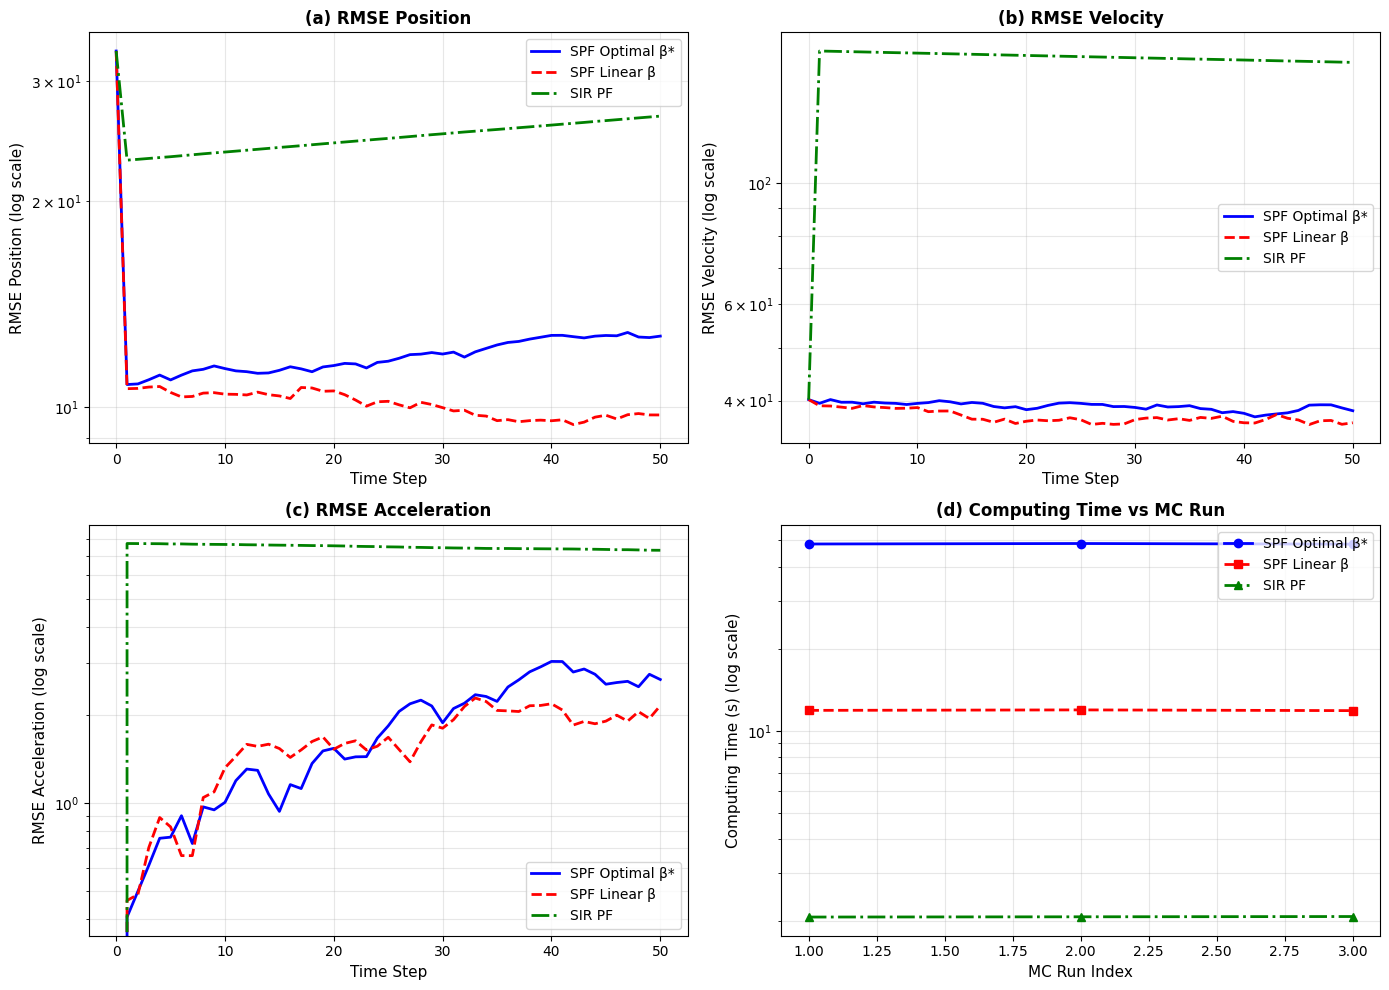


Figure saved to: ../simulator/data/example2_comparison_results.png


In [41]:
# Plot results - Figure with 4 subplots as described in paper
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time steps
time_steps = np.arange(T_steps + 1)

# (a) RMSE Position - LOG SCALE
ax = axes[0, 0]
pos_opt_mean = mc_results['spf_optimal']['pos'].mean(axis=0)
pos_lin_mean = mc_results['spf_linear']['pos'].mean(axis=0)
pos_sir_mean = mc_results['sir_pf']['pos'].mean(axis=0)

ax.semilogy(time_steps, pos_opt_mean, 'b-', label='SPF Optimal β*', linewidth=2)
ax.semilogy(time_steps, pos_lin_mean, 'r--', label='SPF Linear β', linewidth=2)
ax.semilogy(time_steps, pos_sir_mean, 'g-.', label='SIR PF', linewidth=2)
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('RMSE Position (log scale)', fontsize=11)
ax.set_title('(a) RMSE Position', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# (b) RMSE Velocity - LOG SCALE
ax = axes[0, 1]
vel_opt_mean = mc_results['spf_optimal']['vel'].mean(axis=0)
vel_lin_mean = mc_results['spf_linear']['vel'].mean(axis=0)
vel_sir_mean = mc_results['sir_pf']['vel'].mean(axis=0)

ax.semilogy(time_steps, vel_opt_mean, 'b-', label='SPF Optimal β*', linewidth=2)
ax.semilogy(time_steps, vel_lin_mean, 'r--', label='SPF Linear β', linewidth=2)
ax.semilogy(time_steps, vel_sir_mean, 'g-.', label='SIR PF', linewidth=2)
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('RMSE Velocity (log scale)', fontsize=11)
ax.set_title('(b) RMSE Velocity', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# (c) RMSE Acceleration - LOG SCALE
ax = axes[1, 0]
acc_opt_mean = mc_results['spf_optimal']['acc'].mean(axis=0)
acc_lin_mean = mc_results['spf_linear']['acc'].mean(axis=0)
acc_sir_mean = mc_results['sir_pf']['acc'].mean(axis=0)

ax.semilogy(time_steps, acc_opt_mean, 'b-', label='SPF Optimal β*', linewidth=2)
ax.semilogy(time_steps, acc_lin_mean, 'r--', label='SPF Linear β', linewidth=2)
ax.semilogy(time_steps, acc_sir_mean, 'g-.', label='SIR PF', linewidth=2)
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('RMSE Acceleration (log scale)', fontsize=11)
ax.set_title('(c) RMSE Acceleration', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# (d) Computing Time vs MC Run Index - LOG SCALE
ax = axes[1, 1]
n_runs = len(mc_results['spf_optimal']['time'])
run_indices = np.arange(1, n_runs + 1)

ax.semilogy(run_indices, mc_results['spf_optimal']['time'], 'b-o', 
        label='SPF Optimal β*', linewidth=2, markersize=6)
ax.semilogy(run_indices, mc_results['spf_linear']['time'], 'r--s', 
        label='SPF Linear β', linewidth=2, markersize=6)
ax.semilogy(run_indices, mc_results['sir_pf']['time'], 'g-.^', 
        label='SIR PF', linewidth=2, markersize=6)

ax.set_xlabel('MC Run Index', fontsize=11)
ax.set_ylabel('Computing Time (s) (log scale)', fontsize=11)
ax.set_title('(d) Computing Time vs MC Run', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../simulator/data/example2_comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved to: ../simulator/data/example2_comparison_results.png")

In [37]:
# Print numerical summary statistics
print("=" * 80)
print("EXAMPLE 2 RESULTS SUMMARY (20 Monte Carlo Runs)")
print("=" * 80)

print("\n1. POSITION RMSE (averaged over all time steps):")
print(f"   SPF Optimal β*: {mc_results['spf_optimal']['pos'].mean():.4f}")
print(f"   SPF Linear β:   {mc_results['spf_linear']['pos'].mean():.4f}")
print(f"   SIR PF:         {mc_results['sir_pf']['pos'].mean():.4f}")

print("\n2. VELOCITY RMSE (averaged over all time steps):")
print(f"   SPF Optimal β*: {mc_results['spf_optimal']['vel'].mean():.4f}")
print(f"   SPF Linear β:   {mc_results['spf_linear']['vel'].mean():.4f}")
print(f"   SIR PF:         {mc_results['sir_pf']['vel'].mean():.4f}")

print("\n3. ACCELERATION RMSE (averaged over all time steps):")
print(f"   SPF Optimal β*: {mc_results['spf_optimal']['acc'].mean():.4f}")
print(f"   SPF Linear β:   {mc_results['spf_linear']['acc'].mean():.4f}")
print(f"   SIR PF:         {mc_results['sir_pf']['acc'].mean():.4f}")

print("\n4. AVERAGE COMPUTING TIME:")
print(f"   SPF Optimal β*: {mc_results['spf_optimal']['time'].mean():.2f} ± {mc_results['spf_optimal']['time'].std():.2f} s")
print(f"   SPF Linear β:   {mc_results['spf_linear']['time'].mean():.2f} ± {mc_results['spf_linear']['time'].std():.2f} s")
print(f"   SIR PF:         {mc_results['sir_pf']['time'].mean():.2f} ± {mc_results['sir_pf']['time'].std():.2f} s")

print("\n5. PARTICLE COUNTS:")
print(f"   SPF (Optimal/Linear): 100 particles")
print(f"   SIR PF:              10,000 particles")

print("\n6. IMPROVEMENT OF OPTIMAL β* OVER LINEAR β:")
pos_improvement = (mc_results['spf_linear']['pos'].mean() - mc_results['spf_optimal']['pos'].mean()) / mc_results['spf_linear']['pos'].mean() * 100
vel_improvement = (mc_results['spf_linear']['vel'].mean() - mc_results['spf_optimal']['vel'].mean()) / mc_results['spf_linear']['vel'].mean() * 100
acc_improvement = (mc_results['spf_linear']['acc'].mean() - mc_results['spf_optimal']['acc'].mean()) / mc_results['spf_linear']['acc'].mean() * 100

print(f"   Position RMSE:     {pos_improvement:.2f}%")
print(f"   Velocity RMSE:     {vel_improvement:.2f}%")
print(f"   Acceleration RMSE: {acc_improvement:.2f}%")

print("\n" + "=" * 80)

EXAMPLE 2 RESULTS SUMMARY (20 Monte Carlo Runs)

1. POSITION RMSE (averaged over all time steps):
   SPF Optimal β*: 6.5618
   SPF Linear β:   6.6695
   SIR PF:         12.1866

2. VELOCITY RMSE (averaged over all time steps):
   SPF Optimal β*: 22.8479
   SPF Linear β:   23.1342
   SIR PF:         95.6242

3. ACCELERATION RMSE (averaged over all time steps):
   SPF Optimal β*: 0.9027
   SPF Linear β:   1.0190
   SIR PF:         3.4059

4. AVERAGE COMPUTING TIME:
   SPF Optimal β*: 48.48 ± 0.21 s
   SPF Linear β:   11.80 ± 0.05 s
   SIR PF:         2.06 ± 0.01 s

5. PARTICLE COUNTS:
   SPF (Optimal/Linear): 100 particles
   SIR PF:              10,000 particles

6. IMPROVEMENT OF OPTIMAL β* OVER LINEAR β:
   Position RMSE:     1.61%
   Velocity RMSE:     1.24%
   Acceleration RMSE: 11.41%



In [42]:
# Diagnostic: Compare single-step performance for one measurement
print("=== Single-Step Diagnostic ===\n")

# Use first measurement from a trajectory
traj_test, meas_test = simulate_example2_trajectory(config, T=1, dt=dt, seed=999)
x_prior = config.s_prior0
P_prior = np.block([
    [5.0 * np.eye(3),         np.zeros((3, 3)),  np.zeros((3, 3))],
    [np.zeros((3, 3)),        50.0 * np.eye(3),  np.zeros((3, 3))],
    [np.zeros((3, 3)),        np.zeros((3, 3)),  5.0 * np.eye(3)]
])

# Test with different numbers of particles and steps
test_configs = [
    (100, 300, "Current"),
    (500, 500, "More particles & steps"),
    (100, 1000, "More steps only"),
]

for N_test, steps_test, label in test_configs:
    print(f"\n{label}: N={N_test}, n_steps={steps_test}")
    
    # Run optimal
    x_opt, P_opt, info_opt = run_spf_example2_single_step(
        prior_mean=x_prior,
        prior_cov=P_prior,
        measurement=meas_test[0],
        config=config,
        beta_mode="optimal",
        N=N_test,
        n_steps=steps_test
    )
    
    # Run linear
    x_lin, P_lin, info_lin = run_spf_example2_single_step(
        prior_mean=x_prior,
        prior_cov=P_prior,
        measurement=meas_test[0],
        config=config,
        beta_mode="linear",
        N=N_test,
        n_steps=steps_test
    )
    
    # Compute errors relative to truth
    err_opt = np.linalg.norm(x_opt - traj_test[1])
    err_lin = np.linalg.norm(x_lin - traj_test[1])
    
    print(f"  Optimal β* error: {err_opt:.4f}")
    print(f"  Linear β error:   {err_lin:.4f}")
    print(f"  Difference:       {err_opt - err_lin:.4f} ({'Optimal worse' if err_opt > err_lin else 'Optimal better'})")

=== Single-Step Diagnostic ===


Current: N=100, n_steps=300
  Optimal β* error: 41.4535
  Linear β error:   42.5458
  Difference:       -1.0923 (Optimal better)

More particles & steps: N=500, n_steps=500
  Optimal β* error: 41.7403
  Linear β error:   41.5418
  Difference:       0.1985 (Optimal worse)

More steps only: N=100, n_steps=1000
  Optimal β* error: 39.9041
  Linear β error:   41.1643
  Difference:       -1.2602 (Optimal better)


In [43]:
# Check error accumulation over first few time steps
print("\n=== Error Accumulation Over Time ===\n")

traj_short, meas_short = simulate_example2_trajectory(config, T=10, dt=dt, seed=999)

# Run short trajectory for both methods
est_opt_short, _ = run_spf_filter_example2(
    config, meas_short, dt, beta_mode="optimal", N=100, n_steps=300, seed=999
)
est_lin_short, _ = run_spf_filter_example2(
    config, meas_short, dt, beta_mode="linear", N=100, n_steps=300, seed=999
)

print("Time Step | Optimal Error | Linear Error | Difference")
print("-" * 60)
for t in range(min(11, len(traj_short))):
    err_opt = np.linalg.norm(est_opt_short[t] - traj_short[t])
    err_lin = np.linalg.norm(est_lin_short[t] - traj_short[t])
    diff = err_opt - err_lin
    marker = "←" if diff > 0 else "←"
    print(f"{t:9d} | {err_opt:13.4f} | {err_lin:12.4f} | {diff:+10.4f} {marker if abs(diff) > 1 else ''}")


=== Error Accumulation Over Time ===

Time Step | Optimal Error | Linear Error | Difference
------------------------------------------------------------
        0 |       52.0865 |      52.0865 |    +0.0000 
        1 |       42.8339 |      42.1067 |    +0.7273 
        2 |       43.3962 |      42.7284 |    +0.6678 
        3 |       44.2767 |      43.0728 |    +1.2039 ←
        4 |       44.0294 |      43.0761 |    +0.9533 
        5 |       43.1995 |      43.4202 |    -0.2207 
        6 |       42.3247 |      42.6913 |    -0.3666 
        7 |       42.5736 |      41.9016 |    +0.6720 
        8 |       42.1646 |      42.5713 |    -0.4067 
        9 |       42.0340 |      41.7430 |    +0.2910 
       10 |       41.3829 |      42.3503 |    -0.9674 
